# Benchmark speed
# Benchmark Speed Analysis

## Data Collection
Launch the script with logging `benchmark.sh 2>&1 | tee benchmark.txt`

Launch the script with logging to capture benchmark data:
```bash
benchmark.sh 2>&1 | tee benchmark.txt
```



In [16]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import re
import tempfile
sns.set_theme(style="whitegrid")


In [2]:
BENCHMARK_FILE = os.path.expanduser('~/data/2025_benchmark/benchmark.txt')

In [23]:
def parse_benchmark_file(file_path):
    results = []
    current_block = None
    in_job_section = False
    current_job = None

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            # Start of a new bam block
            if re.match('^bams[1-5]$', line.strip()):
                current_stats = []
                current_block = {'name': line, 'stats': current_stats}
                results.append(current_block)
                in_job_section = False
                continue

            # Start of job stats section
            if line.startswith('Job stats:'):
                in_job_section = True
                current_job = {}
                current_stats.append(current_job)
                continue

            # Handle stats section
            if in_job_section:
                if line.startswith('total'):
                    in_job_section = False
                elif line.startswith("call_"):
                    current_job['name'] = line.split(' ')[0]
                continue

            # Look for real time
            if line.startswith('real'):
                current_job['real_time'] = re.sub(',[0-9]+', '', line.split('\t')[1].strip())
                continue

    return results

In [24]:
results = parse_benchmark_file(BENCHMARK_FILE)
results

[{'name': 'bams1',
  'stats': [{'name': 'call_peaks_macs2', 'real_time': '1m2s'},
   {'name': 'call_peaks_macs2', 'real_time': '1m14s'},
   {'name': 'call_peaks_sicer', 'real_time': '4m28s'},
   {'name': 'call_peaks_span', 'real_time': '7m57s'},
   {'name': 'call_peaks_macs3', 'real_time': '1m33s'},
   {'name': 'call_peaks_macs3', 'real_time': '1m44s'},
   {'name': 'call_peaks_sicer2', 'real_time': '1m2s'},
   {'name': 'call_peaks_homer', 'real_time': '1m9s'},
   {'name': 'call_peaks_hotspot', 'real_time': '1m11s'},
   {'name': 'call_peaks_peakseq', 'real_time': '11m52s'},
   {'name': 'call_peaks_fseq2', 'real_time': '10m1s'}]},
 {'name': 'bams2',
  'stats': [{'name': 'call_peaks_macs2', 'real_time': '1m12s'},
   {'name': 'call_peaks_macs2', 'real_time': '1m12s'},
   {'name': 'call_peaks_sicer', 'real_time': '6m40s'},
   {'name': 'call_peaks_span', 'real_time': '8m51s'},
   {'name': 'call_peaks_macs3', 'real_time': '1m47s'},
   {'name': 'call_peaks_macs3', 'real_time': '1m46s'},
   {'n

In [33]:
rows = []
for block in results:
    name = block['name']
    for job in block['stats']:
        peak_caller = job['name'].replace('call_peaks_', '')
        real_time = job['real_time']
        time = re.split('[ms]', real_time)
        time_sec = 60 * int(time[0]) + int(time[1])
        rows.append((name, peak_caller, time_sec))
    rows.append((name, 'bayespeak', 1.5 * 60 * 60))  # 1.5 hours
    rows.append((name, 'gps', 2 * 60 * 60))  # 2 hours
df = pd.DataFrame(rows, columns=['block', 'tool', 'time'])
df

,block,tool,time
0,bams1,macs2,62.0
1,bams1,macs2,74.0
2,bams1,sicer,268.0
3,bams1,span,477.0
4,bams1,macs3,93.0
...,...,...,...
60,bams5,hotspot,55.0
61,bams5,peakseq,626.0
62,bams5,fseq2,540.0
63,bams5,bayespeak,5400.0


Time


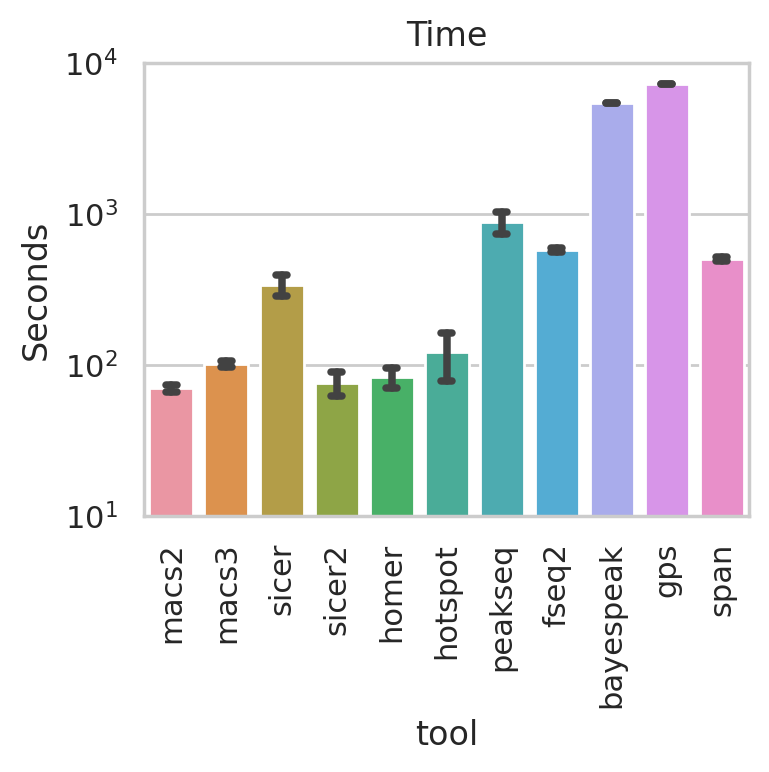

In [44]:
print('Time')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Time')
g_results = sns.barplot(data=df, x='tool', y='time',
                        order=['macs2', 'macs3', 'sicer', 'sicer2', 'homer', 'hotspot', 'peakseq', 'fseq2', 'bayespeak', 'gps', 'span'],
                        capsize=.2,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set(yscale='log')
ax.set_ylim((10, 10_000))
ax.set_ylabel('Peak caller')
ax.set_ylabel('Seconds')
plt.tight_layout()
plt.show()